In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline

## On met le csv dans une dataframe

In [2]:
da = pd.read_csv('bank-additional-full.csv', sep=";")
df = pd.read_csv('bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## On affiche différent graphique pour décrire les données

C:\Users\Hugo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


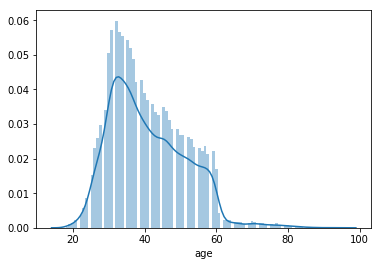

In [4]:
sns.distplot(df.age, bins=100)

C:\Users\Hugo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


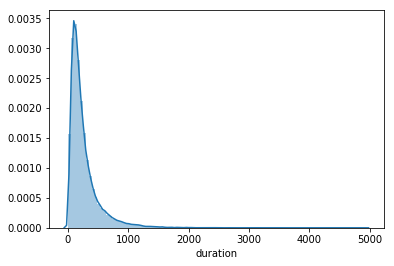

In [5]:
sns.distplot(df.duration, bins=100)

## On regarde les "job" les plus représentés

In [6]:
df_da = df.copy()

In [7]:
df_da.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

## Répartition des résultats des dernières campagnes publicitaires

In [8]:
df_da.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

## On supprime le contact, le mois et le jour du dernier appel, car cela ne nous servira pas pour classifier

In [9]:
df_da.drop('contact', axis=1, inplace=True)
df_da.drop('month', axis=1, inplace=True)
df_da.drop('day', axis=1, inplace=True)

## On transforme tous les champs qui pourraient nous intéresser pour faire une classification

### On les transforme en entier (en créant d'autres colonnes) car c'est beaucoup plus exploitable et ensuite on écrase les anciennes colonnes

In [10]:
df_da['default_cat'] = df_da['default'].map( {'yes':1, 'no':0} )
df_da.drop('default', axis=1,inplace = True)

In [11]:
df_da["housing_cat"]=df_da['housing'].map({'yes':1, 'no':0})
df_da.drop('housing', axis=1,inplace = True)

In [12]:
df_da["loan_cat"] = df_da['loan'].map({'yes':1, 'no':0})
df_da.drop('loan', axis=1, inplace=True)

In [13]:
df_da["deposit_cat"] = df_da['y'].map({'yes':1, 'no':0})
df_da.drop('y', axis=1, inplace=True)

In [14]:
print("Customers that have not been contacted before:", len(df_da[df_da.pdays==999]))

Customers that have not been contacted before: 0


In [15]:
df_da.loc[df_da['pdays'] == 999, 'pdays'] = 10000

## On créer une nouvelle colonne pour qui va évaluer, avec un nombre compris entre 0 et 1, le nombre de jours depuis le dernier appel

### Plus on est proche de 1 plus l'appel est récent

In [16]:
df_da['recent_pdays'] = np.where(df_da['pdays'], 1/df_da.pdays, 1/df_da.pdays)
df_da.drop('pdays', axis=1, inplace = True)
df_da.dropna(inplace=True)

## On transforme les categories job, marital, education et poutcome en dummies, cad en 1 et 0 en fonction de leur valeur

In [17]:
dummies = pd.get_dummies(data=df_da, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])

dummies.head()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,0,0,1,0,0,-1.0,...,1,0,0,0,1,0,0,0,0,1
1,44,29,151,1,0,0,1,0,0,-1.0,...,0,1,0,1,0,0,0,0,0,1
2,33,2,76,1,0,0,1,1,0,-1.0,...,1,0,0,1,0,0,0,0,0,1
3,47,1506,92,1,0,0,1,0,0,-1.0,...,1,0,0,0,0,1,0,0,0,1
4,33,1,198,1,0,0,0,0,0,-1.0,...,0,1,0,0,0,1,0,0,0,1


In [18]:
dummies.shape

(45211, 33)

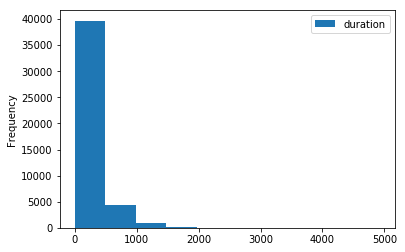

In [19]:
dummies.plot(kind='hist', x='poutcome_success', y='duration');

In [20]:
dummies[df_da.deposit_cat == 1].describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.0,5289.000000,...,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,537.294574,2.141047,1.170354,0.009832,0.365854,0.091511,1.0,-0.635644,...,0.520892,0.361505,0.111741,0.463226,0.377387,0.047646,0.116846,0.058045,0.184912,0.640197
std,13.497781,3501.104777,392.525262,1.921826,2.553272,0.098676,0.481714,0.288361,0.0,0.486940,...,0.499611,0.480482,0.315078,0.498693,0.484779,0.213036,0.321267,0.233851,0.388263,0.479988
min,18.000000,-3058.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,210.000000,244.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,733.000000,426.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,2159.000000,725.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.005128,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,81204.000000,3881.000000,32.000000,58.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#Combien de personnes on fait un placement en ayant un pret conso et un pret immobilier
len(dummies[(dummies.deposit_cat == 1) & (dummies.loan_cat) & (dummies.housing_cat)])

265

In [22]:
#Combien de personnes on fait un placement en ayant déja été à découvert
len(dummies[(dummies.deposit_cat == 1) & (dummies.default_cat ==1)])

52

C:\Users\Hugo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


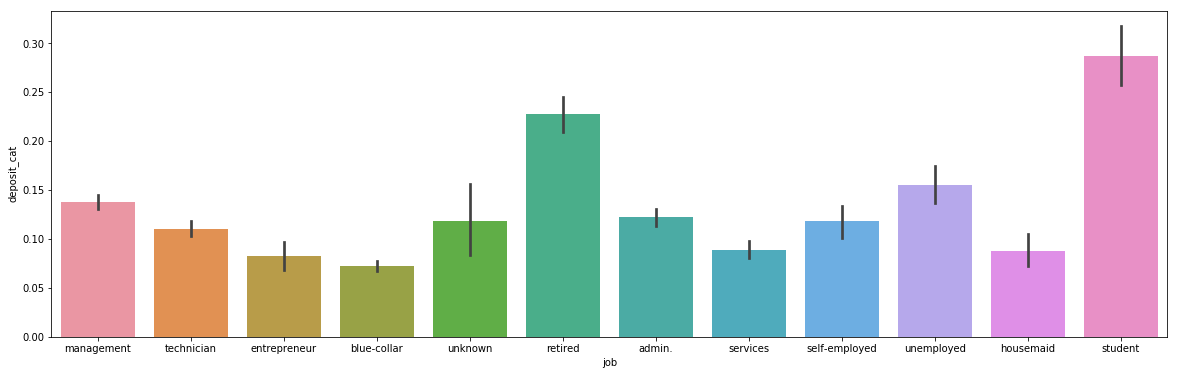

In [23]:
#Quels sont les catégories de travailleurs faisant le plus de placement
plt.figure(figsize = (20,6))
sns.barplot(x='job', y = 'deposit_cat', data = df_da)

C:\Users\Hugo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


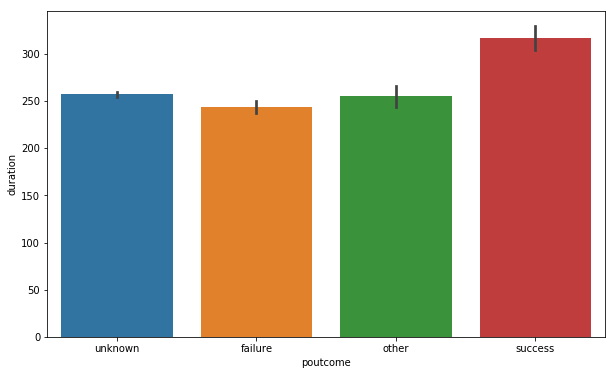

In [24]:
#Moyenne de la durée des appels pour chaque catégories de résultat (réussite ou pas de la dernière campagne publicitaire)
plt.figure(figsize = (10,6))
sns.barplot(x='poutcome', y = 'duration', data = df_da)

In [25]:
cl = dummies

In [26]:
correl = cl.corr()
correl

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,0.097783,-0.004648,0.004760,0.001288,-0.017879,-0.185513,-0.015655,0.025155,0.001537,...,0.286257,-0.427817,0.196182,-0.093979,-0.081629,0.069665,-0.004927,-0.022967,0.035526,-0.000816
balance,0.097783,1.000000,0.021560,-0.014578,0.016674,-0.066745,-0.068768,-0.084350,0.052838,0.029592,...,0.025708,-0.012537,-0.015451,-0.069937,0.084001,0.011181,0.011857,0.008466,0.035240,-0.030271
duration,-0.004648,0.021560,1.000000,-0.084570,0.001203,-0.010021,0.005075,-0.012412,0.394521,0.003346,...,-0.022683,0.020328,-0.003660,0.002084,0.000891,-0.000682,-0.018925,-0.001958,0.042389,-0.003491
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.032855,0.016822,-0.023599,0.009980,-0.073172,-0.108035,...,0.031371,-0.023120,0.009616,-0.020893,0.012866,0.005704,-0.088131,-0.020107,-0.057486,0.107965
previous,0.001288,0.016674,0.001203,-0.032855,1.000000,-0.018329,0.037076,-0.011043,0.093236,0.532164,...,-0.012691,0.017006,-0.016705,-0.005603,0.022888,-0.008257,0.350627,0.306615,0.201424,-0.532763
default_cat,-0.017879,-0.066745,-0.010021,0.016822,-0.018329,1.000000,-0.006025,0.077234,-0.022419,-0.039618,...,-0.014460,0.003115,0.001623,0.013220,-0.015239,-0.001236,-0.026389,-0.014445,-0.023344,0.039490
housing_cat,-0.185513,-0.068768,0.005075,-0.023599,0.037076,-0.006025,1.000000,0.041323,-0.139173,0.061759,...,0.017681,-0.020475,0.010671,0.101659,-0.099175,-0.047595,0.106795,0.039710,-0.091360,-0.063755
loan_cat,-0.015655,-0.084350,-0.012412,0.009980,-0.011043,0.077234,0.041323,1.000000,-0.068185,-0.031149,...,0.036906,-0.051716,-0.012396,0.070625,-0.045940,-0.049992,-0.002186,-0.009099,-0.053713,0.031406
deposit_cat,0.025155,0.052838,0.394521,-0.073172,0.093236,-0.022419,-0.139173,-0.068185,1.000000,0.167015,...,-0.060260,0.063526,-0.040393,-0.036388,0.066448,0.012053,0.009885,0.031955,0.306788,-0.167051
recent_pdays,0.001537,0.029592,0.003346,-0.108035,0.532164,-0.039618,0.061759,-0.031149,0.167015,1.000000,...,-0.025751,0.030766,-0.037080,0.001332,0.029727,-0.004616,0.732039,0.440048,0.394426,-0.997796


## Heatmap de la matrice de correlation

Text(0.5,1,'Heatmap of Correlation Matrix')

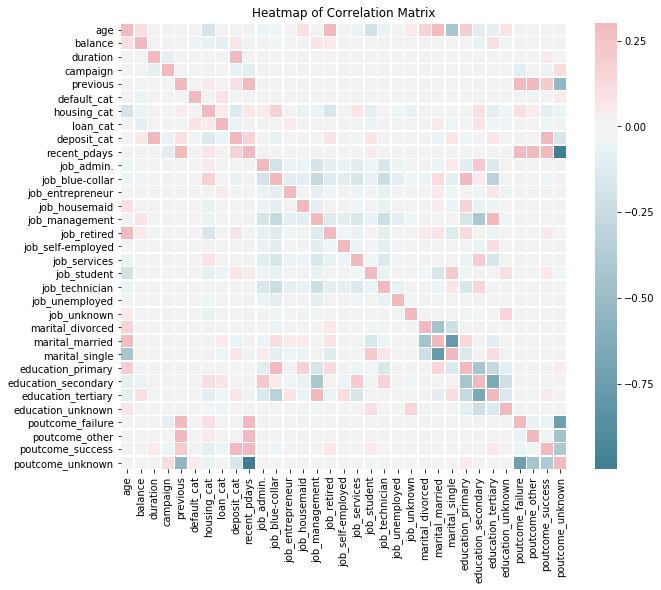

In [27]:
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correl, xticklabels=correl.columns.values, yticklabels=correl.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [28]:
#Cela nous donne les variables qui dépendent le plus d'un placement
corr_deposite = pd.DataFrame(correl['deposit_cat'].drop('deposit_cat'))
corr_deposite.sort_values(by = 'deposit_cat', ascending = False)

,deposit_cat
duration,0.394521
poutcome_success,0.306788
recent_pdays,0.167015
previous,0.093236
job_retired,0.079245
job_student,0.076897
education_tertiary,0.066448
marital_single,0.063526
balance,0.052838
job_management,0.032919


In [29]:
#On sépare le model en train et test (20%)
data_drop_deposite = cl.drop('deposit_cat', 1)
label = cl.deposit_cat
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.2, random_state = 50)

## Arbre de décision à plusieurs profondeurs

In [30]:
dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)
dt2.fit(data_train, label_train)
dt2_score_train = dt2.score(data_train, label_train)
print("Training score: ",dt2_score_train)
dt2_score_test = dt2.score(data_test, label_test)
print("Testing score: ",dt2_score_test)

Training score:  0.8921422251714223
Testing score:  0.8908548048214088


In [31]:
dt3 = tree.DecisionTreeClassifier(random_state=1, max_depth=3)
dt3.fit(data_train, label_train)
dt3_score_train = dt3.score(data_train, label_train)
print("Training score: ",dt3_score_train)
dt3_score_test = dt3.score(data_test, label_test)
print("Testing score: ",dt3_score_test)

Training score:  0.9000774165007742
Testing score:  0.9020236647130377


In [32]:
dt4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)
dt4.fit(data_train, label_train)
dt4_score_train = dt4.score(data_train, label_train)
print("Training score: ",dt4_score_train)
dt4_score_test = dt4.score(data_test, label_test)
print("Testing score: ",dt4_score_test)

Training score:  0.9009345277593452
Testing score:  0.9022448302554462


In [33]:
dt6 = tree.DecisionTreeClassifier(random_state=1, max_depth=6)
dt6.fit(data_train, label_train)
dt6_score_train = dt6.score(data_train, label_train)
print("Training score: ",dt6_score_train)
dt6_score_test = dt6.score(data_test, label_test)
print("Testing score: ",dt6_score_test)

Training score:  0.9040588365405884
Testing score:  0.901249585314608


In [34]:
dt1 = tree.DecisionTreeClassifier()
dt1.fit(data_train, label_train)
dt1_score_train = dt1.score(data_train, label_train)
print("Training score: ", dt1_score_train)
dt1_score_test = dt1.score(data_test, label_test)
print("Testing score: ", dt1_score_test)

Training score:  1.0
Testing score:  0.8575693906889307


In [35]:
#On voit donc que la meilleure profondeur est 4 car c'est la valeur pour laquelle on a le meilleur score pour les données de test

In [44]:
features = cl.columns.tolist()
dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)

# Fit the decision tree classifier
dt2.fit(data_train, label_train)

fi = dt2.feature_importances_

l = len(features)
for i in range(0,l-1):
    print('{:.<30} {:3}'.format(features[i],fi[i]))

age........................... 0.04346670232395117
balance....................... 0.0
duration...................... 0.6172276722112611
campaign...................... 0.0
previous...................... 0.0
default_cat................... 0.0
housing_cat................... 0.012187020648664552
loan_cat...................... 0.0
deposit_cat................... 0.0
recent_pdays.................. 0.0
job_admin..................... 0.0
job_blue-collar............... 0.0
job_entrepreneur.............. 0.0
job_housemaid................. 0.0
job_management................ 0.0
job_retired................... 0.0
job_self-employed............. 0.0
job_services.................. 0.0
job_student................... 0.0
job_technician................ 0.0
job_unemployed................ 0.0
job_unknown................... 0.0
marital_divorced.............. 0.002028743289550929
marital_married............... 0.0
marital_single................ 0.0015170271347819705
education_primary............. 0.0
educati

In [41]:
#On voit donc avec tout ça que la donnée qui a le plus d'importance est la durée de l'appel
print("Mean duration   : ", data_drop_deposite.duration.mean())
print("Maximun duration: ", data_drop_deposite.duration.max())
print("Minimum duration: ", data_drop_deposite.duration.min())

Mean duration   :  258.1630797814691
Maximun duration:  4918
Minimum duration:  0


In [38]:
print(dt2.predict_proba(np.array([0, 0, 258, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 258, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))

[[0.38422649 0.61577351]]
[1]


In [39]:
print(dt2.predict_proba(np.array([0, 0, 4918, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 4918, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))

[[0.47450485 0.52549515]]
[1]


In [ ]:
# 61.6 % de probabilité d'avoir un placement avec un appel de 258 secondes (la moyenne)
# 52.5 % de probabilité d'avoir un placement avec un appel de 4918 secondes (le max)